# Basic_Reconstruction_Template

Neerja Aggarwal
June 16th, 2022

Purpose: Provide skeleton code (well commented!) to adapt to other samples for image reconstruction.  Steps: 
1. Import Packages
2. Set up GPU
3. Import Calibration
4. Import Measurement
5. Load everything onto the GPU
6. Run reconstruction
7. Save results

How to use: Copy this notebook over and adapt as needed. 

ACTION indicates where intervention is needed.
Code is written to be GPU-memory-efficient.

## Import packages

In [1]:
import os
import scipy.signal as sp
%matplotlib inline
# import nbimporter

import sys  
# load the local library
import sdc_config3 as sdc

import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

## Set up GPU

In [2]:
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
# gpu = 3
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# torch.cuda.set_device(gpu)
# device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
device = torch.device('cpu') # uncomment this line to use cpu

print(device)
torch.cuda.empty_cache()  #empty any variables in cache to free up space

# t = torch.cuda.get_device_properties(gpu).total_memory
# r = torch.cuda.memory_reserved(gpu)
# a = torch.cuda.memory_allocated(gpu)
# f = r-a  # free inside reserved

# #print total available memory and used memory (in bytes)
# print(t)
# print(a)

cpu


## Helpers

## Load Calibration Data

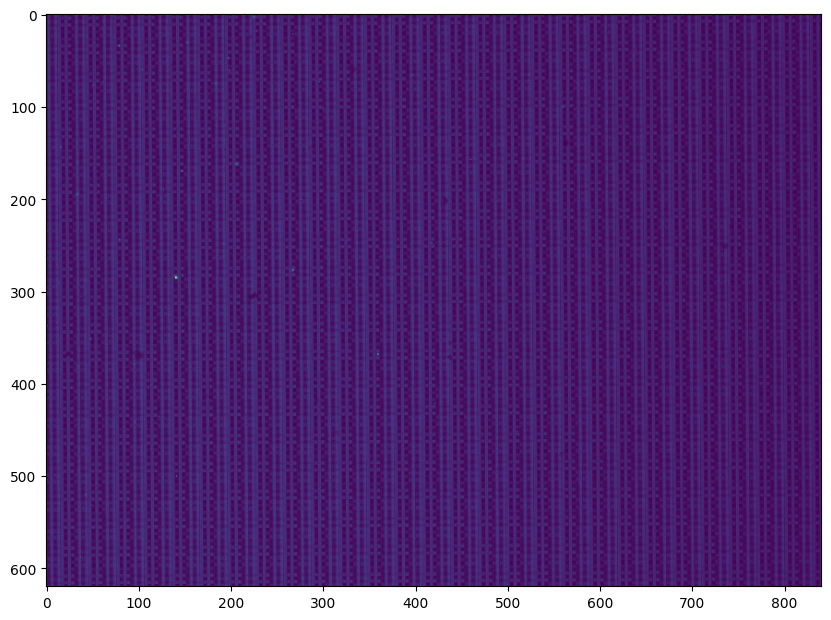

torch.Size([620, 840, 45])


In [3]:
# load filter calibration
datafolder = 'Calibration_Data'
fname = 'filterCal_every2nm_darksub_2021-02-03.mat'
(wv,ci,filterstack) = sdc.importFilterStack(datafolder,fname)

ci2 = [ci[0]-1, ci[1]-1,ci[2],ci[3]]

# decide wavelength sampling
wvmin = 450
wvmax = 800
wvstep = 8
wvnew = np.arange(wvmin,wvmax+wvstep,wvstep)
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)

#normalize the filter array
msum = msum/np.amax(msum)

#set up torch variables
m = torch.tensor(msum)
(dim0,dim1,dim2) = m.shape

plt.figure(figsize = (10,10))
plt.imshow(torch.sum(m,axis=2))
#plt.colorbar()
plt.show()

print(m.shape)

/var/folders/gf/f8h7n1lx2xsc52jqtdrshg3m0000gp/T/ipykernel_49092/2161780741.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))


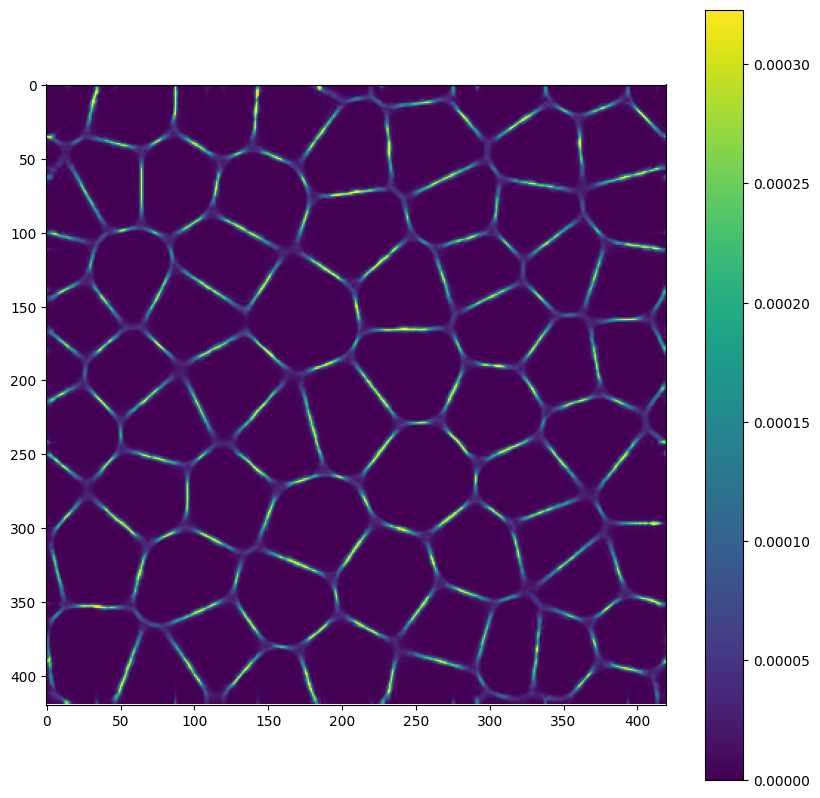

torch.Size([1240, 1680])


In [4]:
# load psf
datafolder = 'Calibration_Data'
# ACTION: choose psf file here
fname = 'psf_300_1.png'
# change the above two lines
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))
plt.figure(figsize = (10,10))
plt.imshow(psf/(50*np.linalg.norm(psf)))
plt.colorbar()
plt.show()

# set up H matrix for convolution
h = sdc.pad2d(psf)  # pad the psf
h = sdc.pad2d(h)
h = h[220:1460,:]
print(h.shape)
h = sdc.make3d(h,dim2) # permute along dim 2
h = sdc.fft3d(h) # take fft along dim 0 and 1

## Load Object

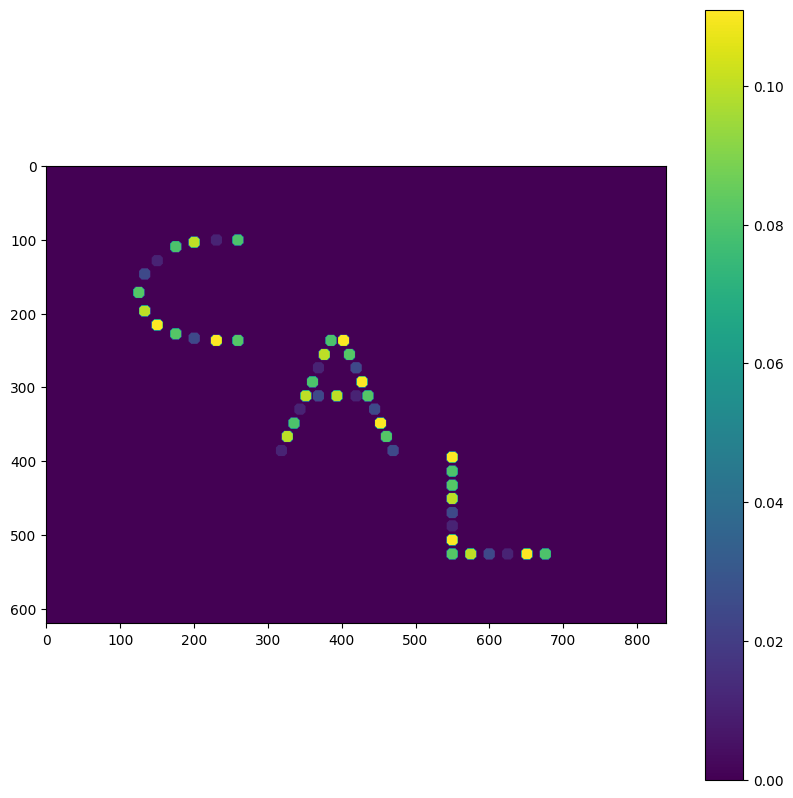

In [5]:
datafolder = 'Sample_Objects/'
fname = 'cal_marbles.npy' # cal_beads_numpy_array
cal_beads = torch.from_numpy(np.load(os.path.join(datafolder, fname)))
plt.figure(figsize = (10,10))
plt.imshow(cal_beads[:,:,0])
plt.colorbar()
# plt.colorbar()
plt.show()

## Create Measurement

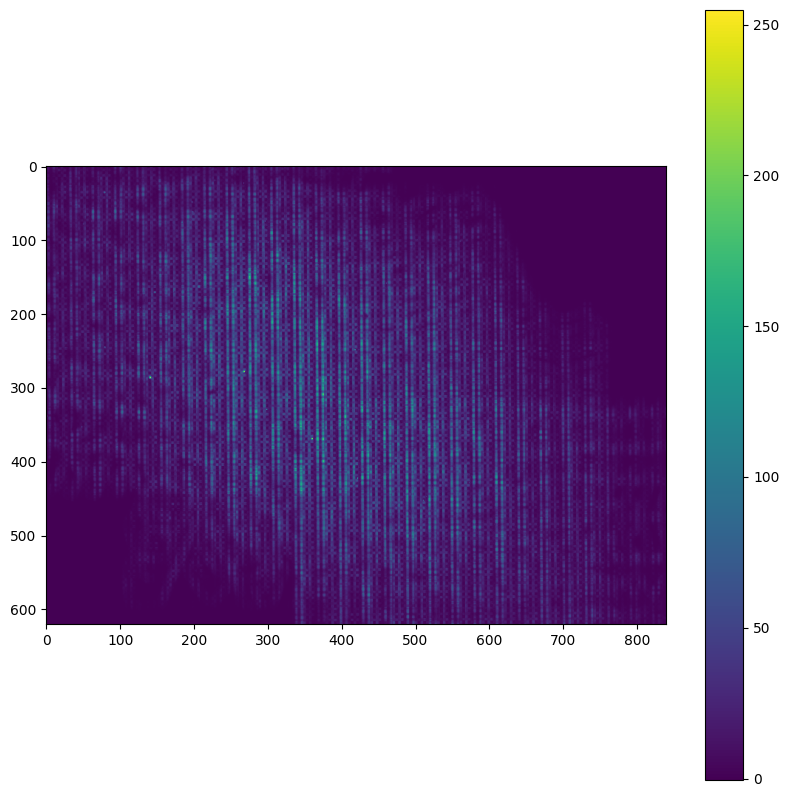

In [6]:
y = sdc.forwardmodel3d(sdc.pad3d(cal_beads), h, m)
y = y / 640
plt.figure(figsize = (10,10))
plt.imshow(y)
plt.colorbar()
plt.show()

## Set up optimization parameters

In [7]:
#ACTION: ADJUST OPTIMIZATION PARAMETERS
specs = dict()
specs['iterations'] = 600 # total iterations to run the optimization for (suggested: 100-1000)
specs['listevery'] = 10 # how often to list iteration number (suggested: 1-10)
specs['step_size'] = 1e-12 # stepsize for gradient descent  (suggested: .01 to 0.5)
specs['tau1'] = 1e-1 # regularizer co-efficient (suggested: 0.1)
specs['print_every'] = 100 # how often to plot iteration progress (suggested: 10-100)
specs['prior'] = 'non-negativity' #can be 'non-negativity' or 'soft-threshold' or 'total-variation'
specs['usegpu'] = 1 # whether to use the gpu (suggested: 1 for ON)

#ACTION: INITIALIZE DATACUBE
xinit = torch.zeros_like(m)
x = sdc.pad3d(xinit)

In [8]:
if specs['usegpu'] == 1:
    #move everything over to gpu
    x=x.to(device)
    h=h.to(device)
    y=y.to(device)
    m=m.to(device)

## Run optimization algorithm

0


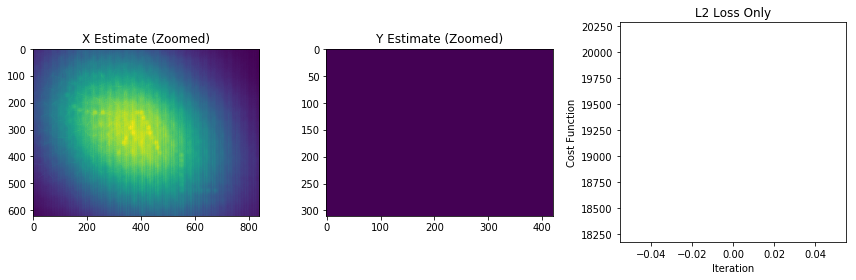

10
20
30
40
50
60
70
80
90
100


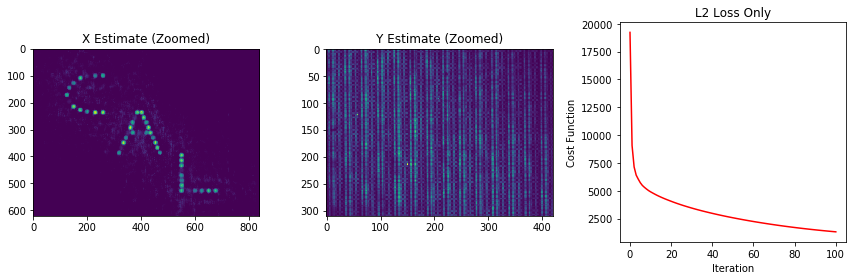

110
120
130
140
150
160
170
180
190
200


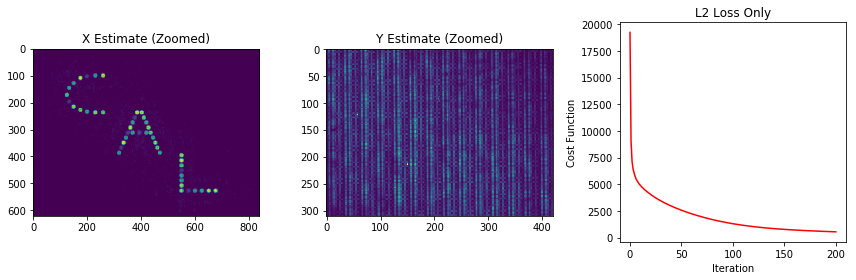

210
220
230
240
250
260
270
280
290
300


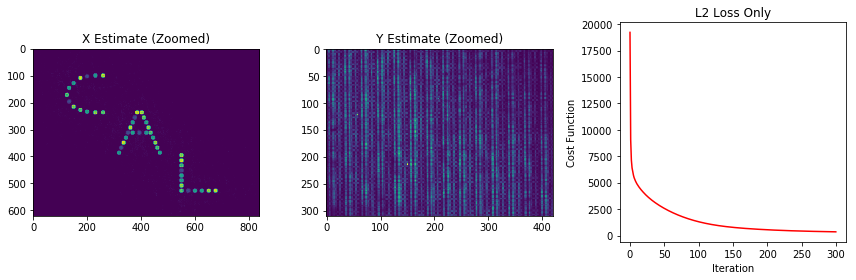

310
320
330
340
350
360
370
380
390
400


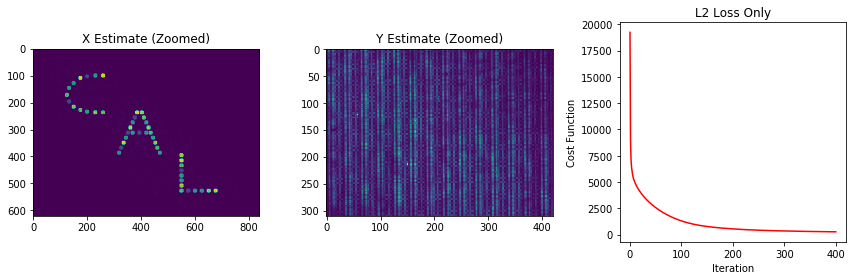

410
420
430
440
450
460
470
480
490
500


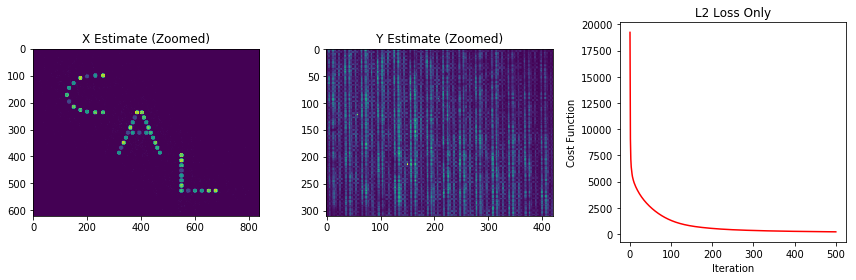

510
520
530
540
550
560
570
580
590
599


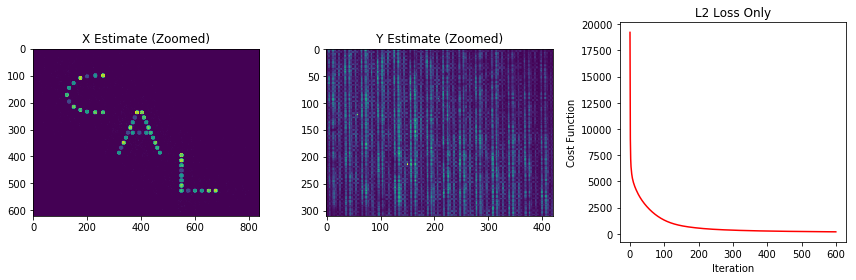

In [9]:
# delete any prior iteration output to free up memory space. 
try:
    del xout
except NameError:
    # Do something.
    pass
torch.cuda.empty_cache()  # need to empty memory even after deleting variables to be sure. 

# run the fista algorithm to reconstruct.  
# outputs are: xout (hyperspectral datacube padded) , l2ll (l2 loss only listed by iteration), ll (total loss listed by iteration)
# (xout,l2ll,ll) = sdc.fistaloop3dGPU(x,h,m,y,specs)
(xout,a,b) = sdc.fistaloop3dGPU(x,h,m,y,specs)

torch.cuda.empty_cache() # clear memory of any remaining function local variables

In [10]:
torch.cuda.empty_cache() # clear memory of any remaining function local variables
t = torch.cuda.get_device_properties(gpu).total_memory
r = torch.cuda.memory_reserved(gpu)
a = torch.cuda.memory_allocated(gpu)
f = r-a  # free inside reserved

#print total available memory and used memory (in bytes)
print(t)
print(r)
print(a)

25447170048
6215958528
4693023744


## Save results

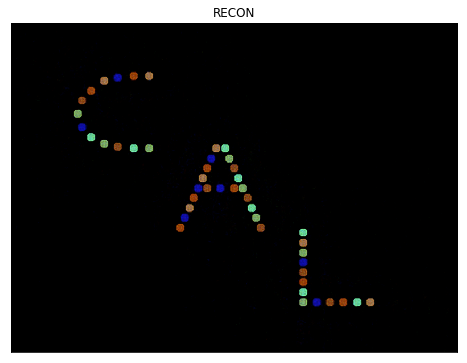

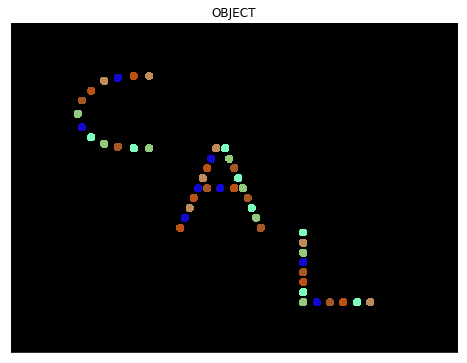

In [11]:
recon = sdc.crop3d(xout).cpu().numpy()
rgbim = sdc.stack_rgb_opt(recon,wvnew)
rgbim = rgbim/np.amax(rgbim)
plt.figure(figsize = (8,8))
# plt.imshow(torch.max(yk,2)[0].cpu())
plt.title('RECON')
plt.imshow(rgbim)
plt.xticks([])
plt.yticks([])
plt.show()

obj = sdc.stack_rgb_opt(cal_beads.cpu().detach().numpy(),wvnew)
obj = obj/np.amax(obj)
plt.figure(figsize = (8,8))
plt.title('OBJECT')
plt.imshow(obj)
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
# ACTION: CHANGE RESULTS FOLDER AND FILENAME
datafolder = 'Results/Custom_Phase_Masks_CALbeadstest'
fname = 'recon_300_1.pt'
torch.save(xout, os.path.join(datafolder, fname))